In [7]:
import numpy as np
import matplotlib.pyplot as plt

import sys, pickle
sys.path.insert(0,'/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC')
import alpha_recoil_sim as ar

In [70]:
data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/radon/po_range/SRIM Outputs Po/'
gas_list = ["N2", "He", "Xe", "Ar", "SF6"]

In [71]:
with open(data_path + 'SRIM_MC_events.pkl', 'rb') as f:
    MC_dict = pickle.load(f)

In [17]:
print(len(MC_dict['He'].keys()))

999


In [34]:
def sim_event(traj_dict, p=10):

    NUM_SRIM_TRAJ = len(traj_dict.keys())

    side_length = 4 ## cm
    length_conv = 1e-7 * 10/p ## nm to cm, pressure factor based on simulations 
                              ## at 10 mbar (assumes lengths increase linearly)

    init_xyz = (np.random.rand(3)-0.5)*side_length

    traj_idx = np.random.choice(NUM_SRIM_TRAJ)+1
    curr_traj = traj_dict[traj_idx] * length_conv
   
    for xyzidx in range(1,4):
        curr_traj[:,xyzidx] -= curr_traj[0,xyzidx] 

    rot_traj = ar.rotate_3d_data(curr_traj[:,1:4], ar.random_angle_on_sphere())

    for xyzidx in range(3):
        curr_traj[:,xyzidx+1] += init_xyz[xyzidx] 

    #print(rot_traj)

    if(np.any( np.abs(curr_traj) > side_length/2)):
        return 0 ## hits wall
    else:
        return 1 ## survives


In [72]:
nmc = int(1e4)
p_list = np.logspace(np.log10(0.1), np.log10(100), 30) #[0.25, 0.5, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 50]

eff_mat = np.zeros((len(p_list), len(gas_list)))

for j,p in enumerate(p_list):
    for k, g in enumerate(gas_list):

        trials_arr = np.zeros(nmc)
        for n in range(nmc):
            trials_arr[n] = sim_event(MC_dict[g], p=p)

        eff_mat[j,k] = np.sum(trials_arr)/nmc

np.savez('recoil_range_data.npz', p=p_list, gas=gas_list, eff_data=eff_mat)

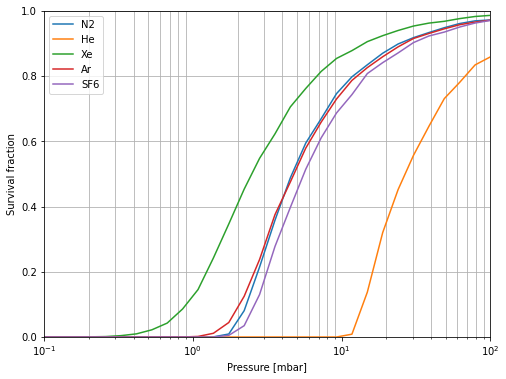

In [68]:
dat = np.load('recoil_range_data.npz')
p_list = dat['p']
gas_list = dat['gas']
eff_mat = dat['eff_data']

plt.figure(figsize=(8,6), facecolor='white')

for k, g in enumerate(gas_list):
    plt.semilogx(p_list, eff_mat[:,k], label=g)

plt.xlabel("Pressure [mbar]")
plt.ylabel("Survival fraction")
plt.grid(True, which='minor', axis='x')
plt.grid(True, which='major', axis='y')
plt.ylim(0,1)
plt.xlim(0.1, 100)
plt.legend()

In [69]:
## parse exyz.txt files from TRIM and save in more efficient python data structure
data_dict = {}

A_to_nm = 0.1 #convert angstrom to nm

for gas in gas_list:

        with open(data_path + "EXYZ_Po216_into_%s_10mbar.txt"%gas) as df:
            lines = df.readlines()
        
        event_dict = {}
        curr_event = -1
        curr_traj_data = []
        for l in lines:
            if not l.startswith("0"): continue 

            curr_dat = l.strip().split()
            line_event = int(curr_dat[0])
            if(curr_event == -1):
                curr_event = line_event

            ## fix rare issue with SRIM files
            try:
                test = [float(curr_dat[1]), float(curr_dat[2]), float(curr_dat[3]), float(curr_dat[4])]
            except:
                continue

            if( abs(line_event - curr_event) < 0.1):
                curr_traj_data.append([float(curr_dat[1]), float(curr_dat[2])*A_to_nm, float(curr_dat[3])*A_to_nm, float(curr_dat[4])*A_to_nm])
            else:
                if( line_event % 10000 == 0 ): 
                    print("Working on %s, event %d"%(gas, line_event))
                event_dict[curr_event] = np.array(curr_traj_data, dtype=float)
                curr_event = line_event
                curr_traj_data = [[float(curr_dat[1]), float(curr_dat[2])*A_to_nm, float(curr_dat[3])*A_to_nm, float(curr_dat[4])*A_to_nm],]

        data_dict[gas] = event_dict

with open(data_path + 'SRIM_MC_events.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    

Working on N2, event 10000
Working on Xe, event 10000
Working on Ar, event 10000
Working on SF6, event 10000
